In [42]:
# !pip install requests

In [174]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

# Packages for Time-Series Analysis
from scipy import interpolate
import itertools
import warnings
from statsmodels.tsa.arima_model import ARIMA
import statsmodels.api as sm
import statsmodels.tsa.api as smt
import statsmodels.formula.api as smf

# Package for Augmented Dickey-Fuller Test
from statsmodels.tsa.stattools import adfuller

# Package for mse
from sklearn.metrics import mean_squared_error as mse

In [44]:
data = pd.read_csv('data/psei_data.csv')

# Data Description

- c: closing price
- h: high price
- l: low price
- o: opening price
- t: date
- v: trading volume
- y: year
- m: month
- d: day
- w: week number
- w: dday of week number
- last: last price
- changeprice: change from last to close
- pchangepercent: price change from last to close
- symbol: stock symbol

In [45]:
data.head()

,c,h,l,o,t,v,y,m,d,w,wd,last,change,pchange,symbol
0,1.66,1.66,1.66,1.66,2006-04-03,250000.0,2006,4,3,14,0,1.66,0.00,0.000000,2GO
1,1.64,1.64,1.64,1.64,2006-04-04,13000.0,2006,4,4,14,1,1.66,-0.02,-0.012048,2GO
2,1.64,1.64,1.60,1.60,2006-04-12,320000.0,2006,4,12,15,2,1.64,0.00,0.000000,2GO
3,1.68,1.68,1.68,1.68,2006-04-20,1000.0,2006,4,20,16,3,1.64,0.04,0.024390,2GO
4,1.68,1.68,1.68,1.68,2006-04-21,3000.0,2006,4,21,16,4,1.68,0.00,0.000000,2GO


In [46]:
data.symbol.unique()

array(['2GO', 'AAA', 'AB', 'ABA', 'ABG', 'ABS', 'ABSP', 'AC', 'ACE',
       'ACPA', 'ACPB2', 'ACR', 'AEV', 'AGI', 'ALCO', 'ALHI', 'ALI', 'ANI',
       'ANS', 'AP', 'APC', 'APL', 'APO', 'APX', 'AR', 'ARA', 'AT', 'ATI',
       'ATN', 'ATNB', 'AUB', 'BC', 'BCB', 'BCOR', 'BDO', 'BEL', 'BHI',
       'BKR', 'BLFI', 'BLOOM', 'BMM', 'BPI', 'BRN', 'BSC', 'CA', 'CAT',
       'CDC', 'CEB', 'CEI', 'CEU', 'CHI', 'CHIB', 'CHP', 'CIC', 'CIP',
       'CNPF', 'COAL', 'COL', 'COSCO', 'CPG', 'CPM', 'CPV', 'CPVB',
       'CROWN', 'CSB', 'CYBR', 'DAVIN', 'DD', 'DDPR', 'DFNN', 'DIZ',
       'DMC', 'DMPL', 'DNA', 'DNL', 'DWC', 'ECP', 'EDC', 'EEI', 'EG',
       'ELI', 'EMP', 'EURO', 'EVER', 'EW', 'FAF', 'FDC', 'FEU', 'FFI',
       'FGEN', 'FGENF', 'FGENG', 'FJP', 'FLI', 'FMETF', 'FNI', 'FOOD',
       'FPH', 'FPHP', 'FPI', 'GEO', 'GERI', 'GLO', 'GLOPP', 'GMA7',
       'GMAP', 'GPH', 'GREEN', 'GSMI', 'GTCAP', 'H2O', 'HI', 'HLCM',
       'HOUSE', 'HVN', 'I', 'ICT', 'IDC', 'IMI', 'IMP', 'ION', 'IPM',
       'IPO'

In [60]:
# Set datetime to proper data type
data['datetime'] = pd.to_datetime(data['t'])

# Set date as index
data.index = data['datetime']

In [52]:
data.dtypes

c                  float64
h                  float64
l                  float64
o                  float64
t                   object
v                  float64
y                    int64
m                    int64
d                    int64
w                    int64
wd                   int64
last               float64
change             float64
pchange            float64
symbol              object
datetime    datetime64[ns]
dtype: object

In [55]:
data['datetime'].min(), data['datetime'].max()

(Timestamp('1983-01-03 00:00:00'), Timestamp('2018-02-19 00:00:00'))

### Pick a Random Stock

In [61]:
data.head(1)

,c,h,l,o,t,v,y,m,d,w,wd,last,change,pchange,symbol,datetime
datetime,,,,,,,,,,,,,,,,
2006-04-03,1.66,1.66,1.66,1.66,2006-04-03,250000.0,2006,4,3,14,0,1.66,0.0,0.0,2GO,2006-04-03


In [126]:
stock = 'BPI'
date_from = '2016'
date_to = '2018'

In [192]:
bpi_data = data[data['symbol']==stock][date_from:date_to].sort_index()[['c','last']]

In [193]:
bpi_data

,c,last
datetime,,
2016-01-04,83.20,83.85
2016-01-05,83.05,83.20
2016-01-06,82.00,83.05
2016-01-07,81.70,82.00
2016-01-08,82.00,81.70
2016-01-11,81.25,82.00
2016-01-12,83.10,81.25
2016-01-13,84.90,83.10
2016-01-14,84.55,84.90


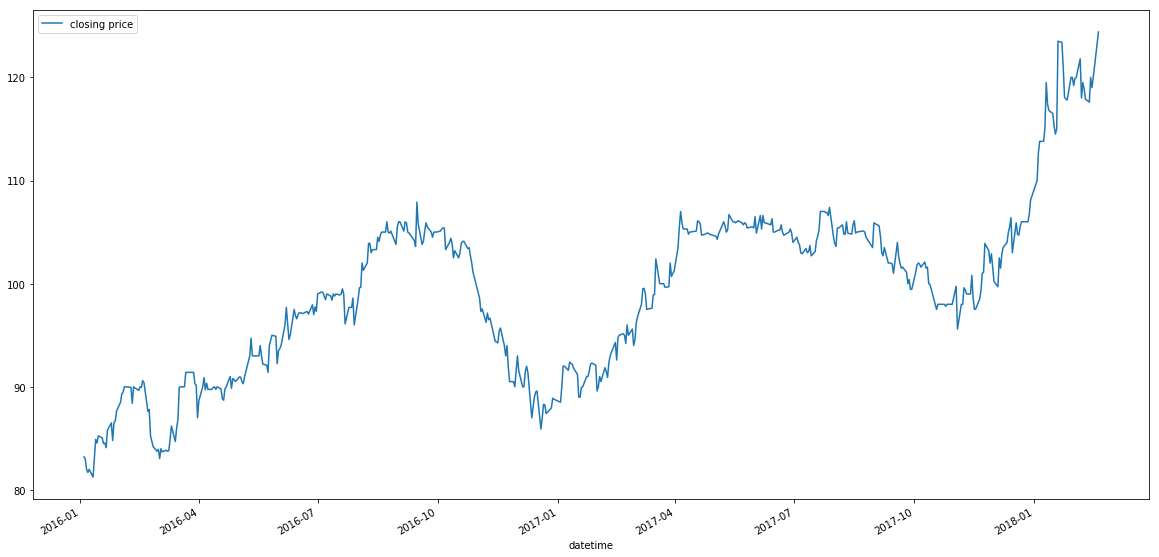

In [129]:
plt.subplots(figsize=(20, 10))
bpi_data.c.plot(label='closing price')
plt.legend()

### 20-EMA and 50-EMA on BPI Data

These smoothing functions are more commonly used as indicators for buy and sell.

In [130]:
# Calculate EMAs
bpi_data['ema_20'] = bpi_data['c'].ewm(span=20, min_periods=0, adjust=False, ignore_na=False).mean()
bpi_data['ema_50'] = bpi_data['c'].ewm(span=50, min_periods=0, adjust=False, ignore_na=False).mean()

# Calculate Derivative of EMAS
bpi_data['dema_20'] = bpi_data['ema_20'].diff()
bpi_data['dema_50'] = bpi_data['ema_50'].diff()

In [131]:
bpi_data.head()

,c,ema_20,ema_50,dema_20,dema_50
datetime,,,,,
2016-01-04,83.20,83.200000,83.200000,NaN,NaN
2016-01-05,83.05,83.185714,83.194118,-0.014286,-0.005882
2016-01-06,82.00,83.072789,83.147290,-0.112925,-0.046828
2016-01-07,81.70,82.942047,83.090533,-0.130742,-0.056756
2016-01-08,82.00,82.852329,83.047767,-0.089719,-0.042766


# BPI Closing Prices with EMA Indicators

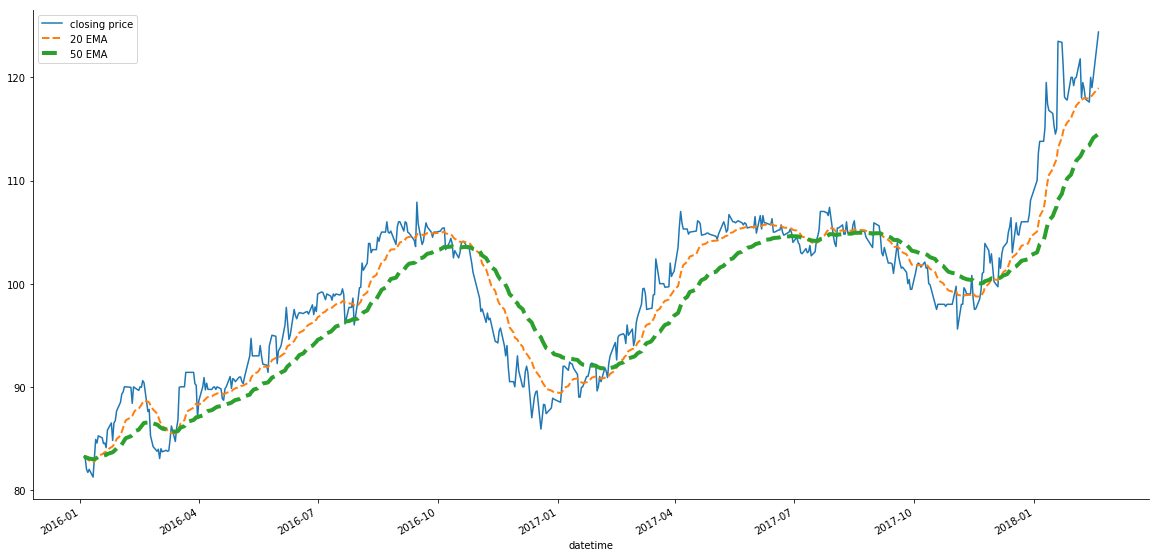

In [132]:
ax = plt.subplot()
ax = bpi_data.c.plot(label='closing price', figsize=(20, 10))
bpi_data.ema_20.plot(label='20 EMA', style='--', linewidth=2, ax=ax)
bpi_data.ema_50.plot(label='50 EMA', style='--', linewidth=4,  ax=ax)
plt.legend()

# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

Generally: 
- if the larger EMA crosses above the smaller EMA, this signals a buy.
- if the larger EMA crosses below the smaller EMA, this signals a sell.

### Extract Crossing Instances

These instances indicate when we should buy or sell.

In [133]:
previous_20 = bpi_data['ema_20'].shift(1)
previous_50 = bpi_data['ema_50'].shift(1)
crossing_sell = ((bpi_data['ema_20'] <= bpi_data['ema_50']) & (previous_20 >= previous_50))
crossing_buy =  ((bpi_data['ema_20'] >= bpi_data['ema_50']) & (previous_20 <= previous_50))


# Sell Dates
bpi_data.loc[crossing_buy]

# Buy Dates
bpi_data.loc[crossing_sell]

In [134]:
# Sell Dates
bpi_data.loc[crossing_buy]

,c,ema_20,ema_50,dema_20,dema_50
datetime,,,,,
2016-01-15,85.25,83.301813,83.199523,0.205072,0.083693
2016-03-17,89.95,86.062667,85.878387,0.409193,0.166188
2017-02-16,94.80,92.136865,92.133331,0.280330,0.108844
2017-07-21,107.00,104.399202,104.318855,0.273768,0.109434
2017-12-05,102.50,100.554483,100.552001,0.204791,0.079510


In [135]:
# Buy Dates
bpi_data.loc[crossing_sell]

,c,ema_20,ema_50,dema_20,dema_50
datetime,,,,,
2016-01-05,83.05,83.185714,83.194118,-0.014286,-0.005882
2016-03-08,83.75,85.747977,85.781748,-0.210313,-0.082928
2016-11-02,98.60,102.950627,103.177168,-0.457961,-0.186823
2017-07-11,103.00,104.311594,104.323720,-0.138062,-0.054029
2017-09-06,103.00,104.773651,104.811107,-0.186700,-0.073923


# Forecast The Future

Since we we want to know these buy and sell signals ahead of time, we'll try to see if past trends, forecasts the future.

### Clean Stock Price Signal

In [296]:
pd.plotting.register_matplotlib_converters()

In [292]:
# Use only 2016 - 2018 data and resample to daily closing price
y_orig = bpi_data['c']
yn = bpi_data['c'].resample('D').max()

# Get 'last price'
yn_last = bpi_data['last'].resample('D').max().shift(-1)

# Use 'last price' to fill NaN values of the closing prices.
yn.fillna(yn_last, inplace=True)

# Use average of previous and after to fill NaN values and itearte until no more null values are unimputed
while yn.isna().sum() > 0:
    yn_forward = yn.shift(1)
    yn_backward = yn.shift(-1)
    yn_mean = pd.concat([yn_forward, yn_backward], axis=1).mean(axis=1)
    yn.fillna(yn_mean, inplace=True)

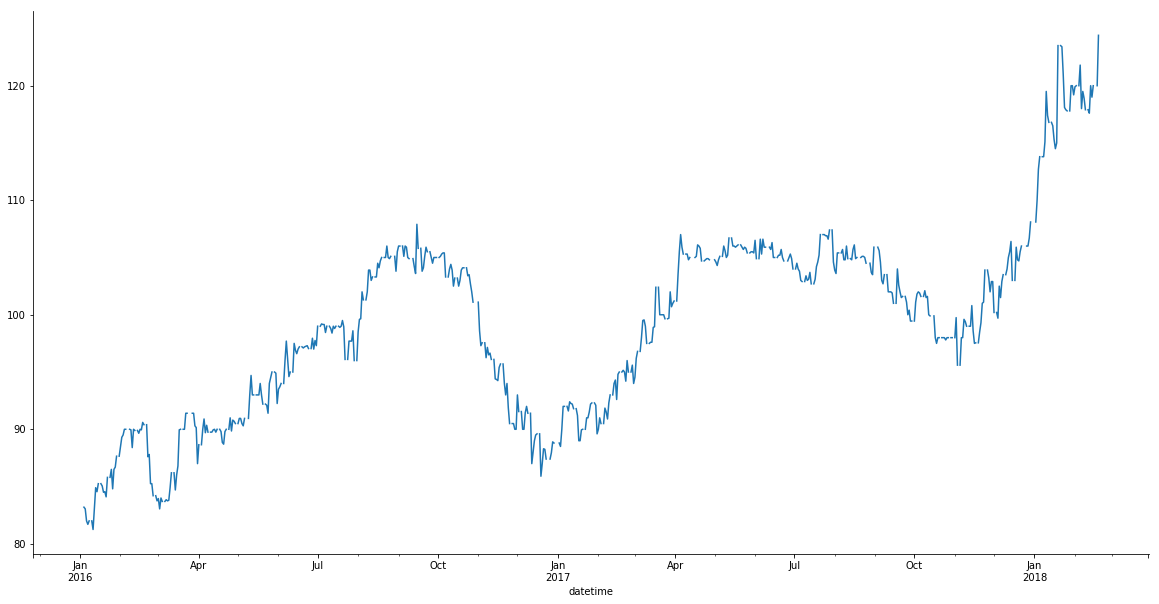

In [298]:
ax = plt.subplot()
ax = yn.plot(label='closing price', figsize=(20, 10))


# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

### Augmented Dickey-Fuller Test
Are the returns Stationary?  
With the assumption that our null hypothesis states that the time-series data is non-stationary, we perform the augmented Dickey-Fuller Test

In [299]:
# Perform DF Test
DFtest = adfuller(yn, autolag='AIC') 

DFoutput = pd.Series(DFtest[0:4], index=['test statistic', 'p-value', '#lags Used', 'Num_obs'])

for key, value in DFtest[4].items():
        DFoutput['Critical Value (%s)'%key] = value
    

DFoutput

LinAlgError: SVD did not converge

### Result
Since the test-statistic value is absolutely higher than the critical value (at any percent), we can't reject the null hypothesis. Meaning, the time-series data we have is statistically non-stationary.

###  Convert to Stationary

In [244]:
# lets try to make the SPY stationary

tsmlog = np.log10(yn)
tsmlog.dropna(inplace=True)

tsmlogdiff = tsmlog.diff(periods=1)
tsmlogdiff.dropna(inplace=True)

# Stationarity Check
# Perform DF Test
DFtest_ = adfuller(tsmlogdiff, autolag='AIC') 

DFoutput_ = pd.Series(DFtest_[0:4], index=['test statistic', 'p-value', '#lags Used', 'Num_obs'])

for key, value in DFtest_[4].items():
        DFoutput_['Critical Value (%s)'%key] = value
    

DFoutput_

test statistic         -1.794806e+01
p-value                 2.845096e-30
#lags Used              2.000000e+00
Num_obs                 7.740000e+02
Critical Value (1%)    -3.438827e+00
Critical Value (5%)    -2.865281e+00
Critical Value (10%)   -2.568762e+00
dtype: float64

### Convert to Stationary Insights  

Since we have test-statistic < critical values, then we have converted the time-series into a stationary one.  Since we see that we can convert the data to stationary through simple shifted differencing, we can grid search on th original time-series data and let d handle for the stationarity.

### ACF and PACF Plots
ACF & PACF graphs are used to visualize AR & MA components.

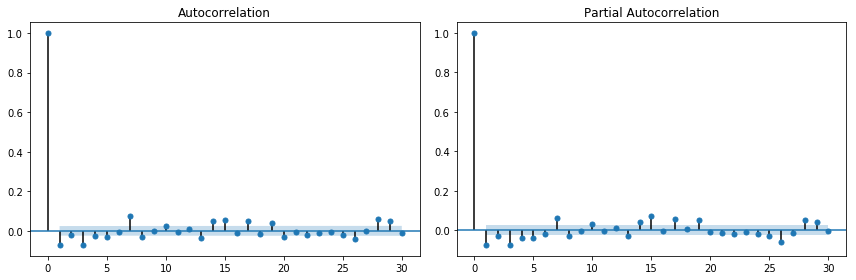

In [245]:
fig, axes = plt.subplots(1, 2)
fig.set_figwidth(12)
fig.set_figheight(4)
smt.graphics.plot_acf(tsmlogdiff, lags=30, ax=axes[0], alpha=0.5)
smt.graphics.plot_pacf(tsmlogdiff, lags=30, ax=axes[1], alpha=0.5)
plt.tight_layout()

We try to deduce some sort of seasonality in the data by taking the aggregate weekly averages of the BPI stock closing prices.

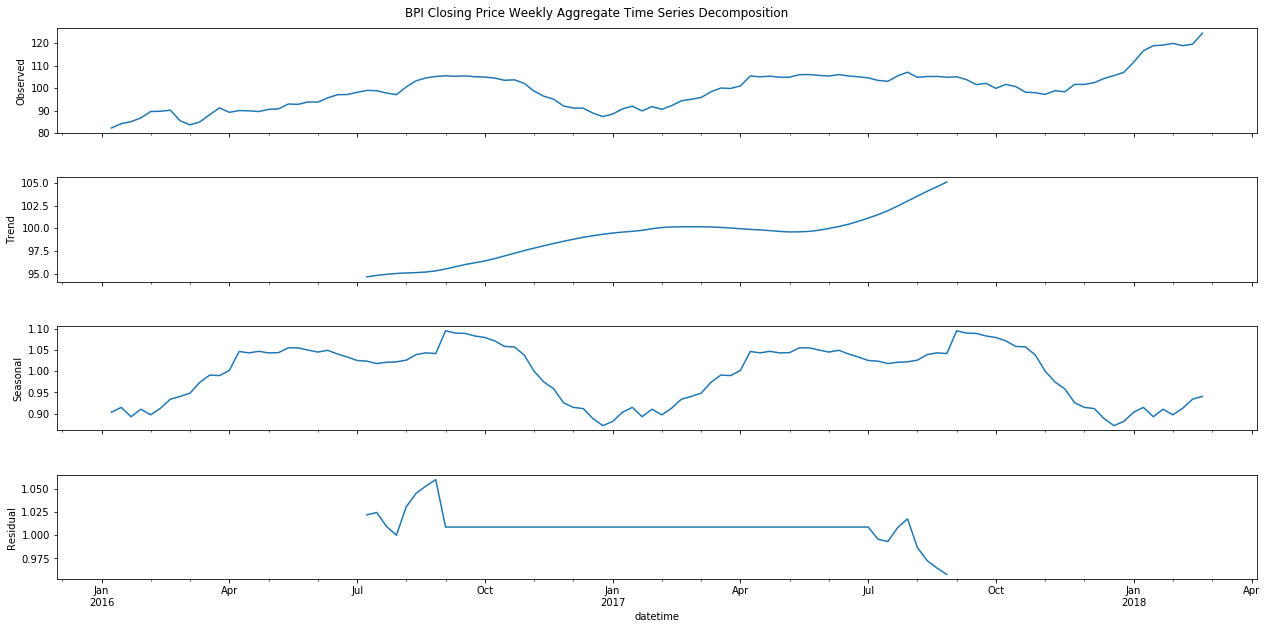

In [246]:
# Decompose trend seasonality resampling data to weekly averages
decomp = sm.tsa.seasonal_decompose(yn.resample('W').mean(), model='multiplicative')

fig = decomp.plot()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('BPI Closing Price Weekly Aggregate Time Series Decomposition')
plt.show()

### BPI Closing Price Monthly Averages
We do the same for monthly aggregates to see which one has a better seasonality trend.

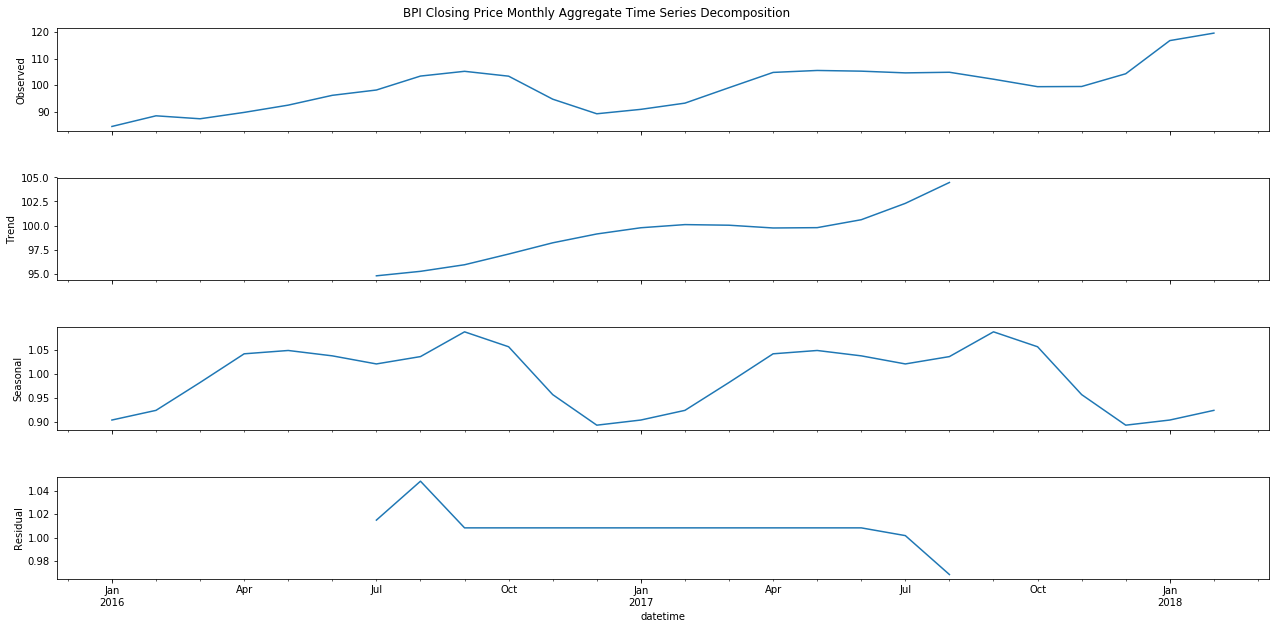

In [247]:
# Decompose trend seasonality resampling data to Monhtly averages
decomp = sm.tsa.seasonal_decompose(yn.resample('M').mean(), model='multiplicative')

fig = decomp.plot()
fig.set_figwidth(20)
fig.set_figheight(10)
fig.suptitle('BPI Closing Price Monthly Aggregate Time Series Decomposition')
plt.show()

Both resampling methods show an increasing trend and both showing similar seasonality. We can just stick with weekly seasonality (7-day).

### Grid Search

In [248]:
def standardization(data):
    mean = np.mean(data)
    std = np.std(data)
    return (data-mean)/std, mean, std

def standardization_invert(data, mean, std):
    return data*std + mean

def gridSearch(y):
    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)
    ssn = [7, 14, 30]

    # Generate all different combinations of p, q and q triplets
    pdqs = list(itertools.product(p, d, q, ssn))

    # Generate all different combinations of seasonal p, q and q triplets
    seasonal_pdq = [(x[0], x[1], x[2], x[3]) for x in pdqs]

    warnings.filterwarnings("ignore") # specify to ignore warning messages
    aic = []
    for param in pdqs:
        for param_seasonal in seasonal_pdq:
            try:
                ydata, _, _ = standardization(y)
                mod = sm.tsa.statespace.SARIMAX(ydata,
                                                order=param,
                                                seasonal_order=param_seasonal,
                                                enforce_stationarity=False,
                                                enforce_invertibility=False)

                results = mod.fit()
                aic.append([param, param_seasonal, results.aic])
                print('order={}, seasonality={}, - AIC:{}'.format(param, param_seasonal, results.aic))
            except:
                continue
    return aic
  
  

Let's cycle through all possible combinations of SARIMAX parameters and get lowest AIC

In [157]:
%%time

aic_y = gridSearch(yn)

order=(0, 0, 0, 7), seasonality=(0, 0, 1, 7), - AIC:975.176956625254
order=(0, 0, 0, 7), seasonality=(0, 0, 1, 14), - AIC:996.601132985623
order=(0, 0, 0, 7), seasonality=(0, 0, 1, 30), - AIC:1098.8412784215093
order=(0, 0, 0, 7), seasonality=(0, 1, 1, 7), - AIC:290.5057673999796
order=(0, 0, 0, 7), seasonality=(0, 1, 1, 14), - AIC:640.6072797822953
order=(0, 0, 0, 7), seasonality=(0, 1, 1, 30), - AIC:986.7315941400682
order=(0, 0, 0, 7), seasonality=(1, 0, 0, 7), - AIC:288.22389806271923
order=(0, 0, 0, 7), seasonality=(1, 0, 0, 14), - AIC:668.1492961610131
order=(0, 0, 0, 7), seasonality=(1, 0, 0, 30), - AIC:1095.7062802180444
order=(0, 0, 0, 7), seasonality=(1, 0, 1, 7), - AIC:286.1525490861046
order=(0, 0, 0, 7), seasonality=(1, 0, 1, 14), - AIC:641.9503741784129
order=(0, 0, 0, 7), seasonality=(1, 0, 1, 30), - AIC:975.0722606799714
order=(0, 0, 0, 7), seasonality=(1, 1, 0, 7), - AIC:289.4914922110528
order=(0, 0, 0, 7), seasonality=(1, 1, 0, 14), - AIC:634.2143305719547
order=(0, 

In [261]:
sorted_list_aic = sorted(aic_y, key=lambda x:np.abs(x[2]))
sorted_list_aic[:40]

[[(0, 0, 1, 7), (1, 1, 1, 7), 0.06252443038874134],
 [(0, 0, 1, 14), (1, 1, 1, 7), 0.06252443038874134],
 [(0, 0, 1, 30), (1, 1, 1, 7), 0.06252443038874134],
 [(0, 0, 1, 7), (0, 1, 1, 7), -0.47715676970619825],
 [(0, 0, 1, 14), (0, 1, 1, 7), -0.47715676970619825],
 [(0, 0, 1, 30), (0, 1, 1, 7), -0.47715676970619825],
 [(0, 0, 1, 7), (0, 1, 0, 7), 0.5195535623079088],
 [(0, 0, 1, 14), (0, 1, 0, 7), 0.5195535623079088],
 [(0, 0, 1, 30), (0, 1, 0, 7), 0.5195535623079088],
 [(0, 0, 1, 7), (1, 1, 0, 7), -2.1327198468284667],
 [(0, 0, 1, 14), (1, 1, 0, 7), -2.1327198468284667],
 [(0, 0, 1, 30), (1, 1, 0, 7), -2.1327198468284667],
 [(0, 0, 1, 7), (1, 0, 1, 7), -9.668864415909319],
 [(0, 0, 1, 14), (1, 0, 1, 7), -9.668864415909319],
 [(0, 0, 1, 30), (1, 0, 1, 7), -9.668864415909319],
 [(0, 0, 1, 7), (1, 0, 0, 7), -11.727080848355683],
 [(0, 0, 1, 14), (1, 0, 0, 7), -11.727080848355683],
 [(0, 0, 1, 30), (1, 0, 0, 7), -11.727080848355683],
 [(1, 1, 0, 7), (0, 1, 0, 7), -147.49556939968826],
 [(

### AIC Results

We take the algebraically lowest AIC.

In [262]:
best_param = sorted_list_aic[0]
best_param

[(0, 0, 1, 7), (1, 1, 1, 7), 0.06252443038874134]

In [270]:
mod = sm.tsa.statespace.SARIMAX(yn[:'2018-01-01'], 
                                order=best_param[0], 
                                seasonal_order=best_param[1],   
                                enforce_stationarity=False,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

                                 Statespace Model Results                                
Dep. Variable:                                 c   No. Observations:                  729
Model:             SARIMAX(0, 0, 1)x(1, 1, 1, 7)   Log Likelihood               -1284.674
Date:                           Fri, 16 Aug 2019   AIC                           2577.347
Time:                                   12:39:42   BIC                           2595.714
Sample:                               01-04-2016   HQIC                          2584.434
                                    - 01-01-2018                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1          0.6298      0.030     20.979      0.000       0.571       0.689
ar.S.L7       -0.3358      0.154     -2.181

### Model Diagnostics
The p-value of each coef is close to zero and hence we include the features in our model.  
We run some diagnostics in the model to see if assumptions still hold and/or some trends weren't captured.

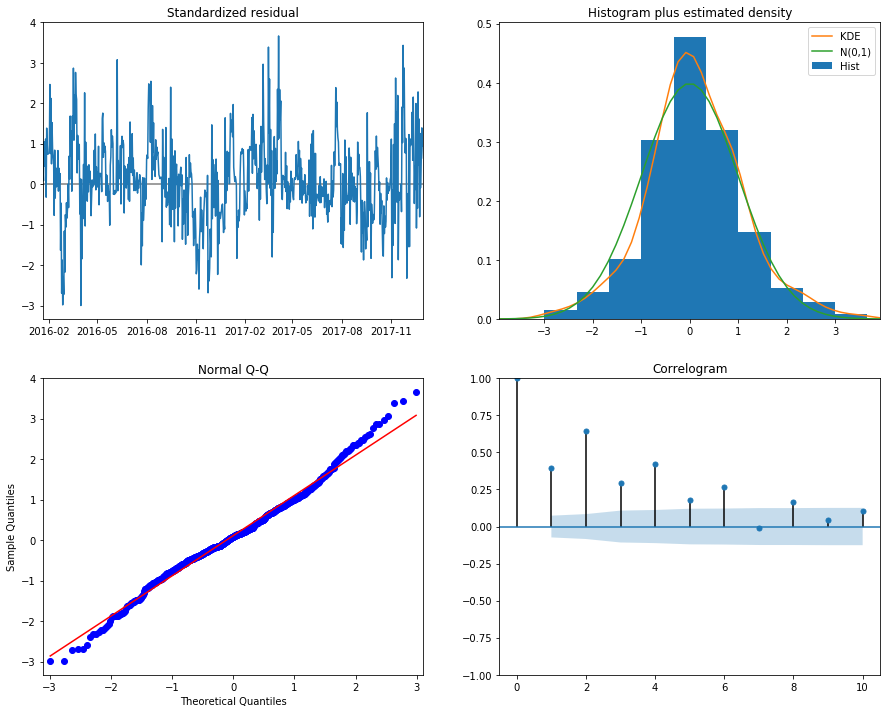

In [271]:
results.plot_diagnostics(figsize=(15, 12))
plt.show()

In [272]:
yn.tail(20)

datetime
2018-01-31    119.2
2018-02-01    119.9
2018-02-02    120.0
2018-02-03    120.0
2018-02-04    120.0
2018-02-05    121.8
2018-02-06    118.0
2018-02-07    119.5
2018-02-08    118.9
2018-02-09    117.9
2018-02-10    117.9
2018-02-11    117.9
2018-02-12    117.6
2018-02-13    120.0
2018-02-14    119.0
2018-02-15    120.0
2018-02-16    120.0
2018-02-17    120.0
2018-02-18    120.0
2018-02-19    124.4
Freq: D, Name: c, dtype: float64

In [277]:
pred = results.get_prediction(start='2017-12-01', end='2018-03-31', dynamic=False)
pred_ci = pred.conf_int()
pred_ci.tail(20)

,lower c,upper c
2018-03-12,98.417878,117.204501
2018-03-13,96.625734,116.056457
2018-03-14,95.951613,115.632013
2018-03-15,96.665509,116.345909
2018-03-16,98.038934,117.719334
2018-03-17,98.038934,117.719334
2018-03-18,98.038934,117.719334
2018-03-19,97.970983,117.651383
2018-03-20,96.193020,116.489170
2018-03-21,95.524161,116.059468


In [278]:
pred.predicted_mean.tail(20)

2018-03-12    107.811190
2018-03-13    106.341095
2018-03-14    105.791813
2018-03-15    106.505709
2018-03-16    107.879134
2018-03-17    107.879134
2018-03-18    107.879134
2018-03-19    107.811183
2018-03-20    106.341095
2018-03-21    105.791814
2018-03-22    106.505710
2018-03-23    107.879136
2018-03-24    107.879136
2018-03-25    107.879136
2018-03-26    107.811185
2018-03-27    106.341095
2018-03-28    105.791814
2018-03-29    106.505710
2018-03-30    107.879135
2018-03-31    107.879135
Freq: D, dtype: float64

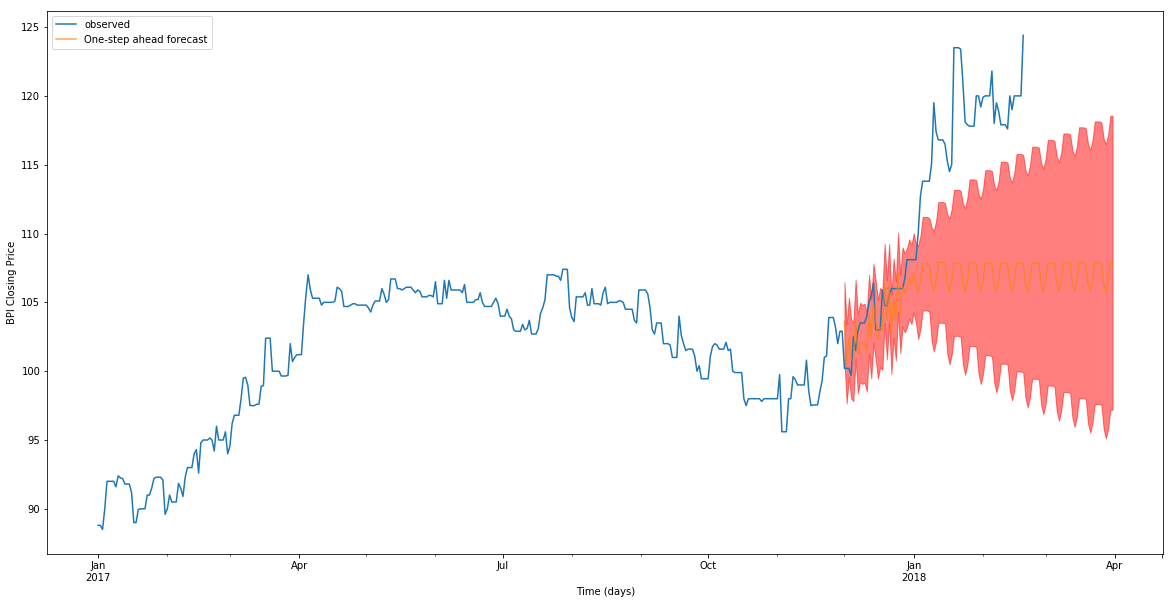

In [279]:
ax = yn['2017-01-01':].plot(label='observed', figsize = (20, 10))
pred.predicted_mean.plot(ax=ax, label='One-step ahead forecast', alpha=.7)

ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='r', alpha=.5)

ax.set_xlabel('Time (days)')
ax.set_ylabel('BPI Closing Price')
plt.legend()

plt.show()

# Forcast using Prophet

Prophet is an open source library published by Facebook that is based on decomposable (trend+seasonality+holidays) models. It provides us with the ability to make time series predictions with good accuracy using simple intuitive parameters and has support for including impact of custom seasonality and holidays!

Here's the resource for more information on [Prophet](https://www.analyticsvidhya.com/blog/2018/05/generate-accurate-forecasts-facebook-prophet-python-r/).

In [276]:
!pip install fbprophet

     |████████████████████████████████| 51kB 526kB/s 
     |████████████████████████████████| 37.4MB 70kB/s 
     |████████████████████████████████| 10.2MB 132kB/s 
     |████████████████████████████████| 81kB 127kB/s 
     |████████████████████████████████| 747kB 129kB/s 
  ERROR: Command errored out with exit status 1:
   command: /anaconda3/bin/python -u -c 'import sys, setuptools, tokenize; sys.argv[0] = '"'"'/private/var/folders/mg/27yjhrgs399dngjcmmdp58m40000gn/T/pip-install-awwl1q4t/fbprophet/setup.py'"'"'; __file__='"'"'/private/var/folders/mg/27yjhrgs399dngjcmmdp58m40000gn/T/pip-install-awwl1q4t/fbprophet/setup.py'"'"';f=getattr(tokenize, '"'"'open'"'"', open)(__file__);code=f.read().replace('"'"'\r\n'"'"', '"'"'\n'"'"');f.close();exec(compile(code, __file__, '"'"'exec'"'"'))' bdist_wheel -d /private/var/folders/mg/27yjhrgs399dngjcmmdp58m40000gn/T/pip-wheel-w2lvjaeq --python-tag cp36
       cwd: /private/var/folders/mg/27yjhrgs399dngjcmmdp58m40000gn/T/pip-install-awwl1q4t/fbpr

In [282]:
from fbprophet import Prophet
pd.options.display.max_columns = 999

In [301]:
yn.fillna(method='ffill', inplace=True)

In [304]:
yn_df = pd.DataFrame(yn)
yn_df['y'] = yn_df['c']
yn_df['ds'] = yn_df.index

In [343]:
date_split = '2018-01-01'
train, test = yn_df[:date_split], yn_df[date_split:]

In [382]:
test.shape

(50, 3)

In [384]:
m = Prophet(yearly_seasonality = True, weekly_seasonality=True, seasonality_prior_scale=0.1)
m.fit(train)
future = m.make_future_dataframe(periods=(80))
forecast = m.predict(future)

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


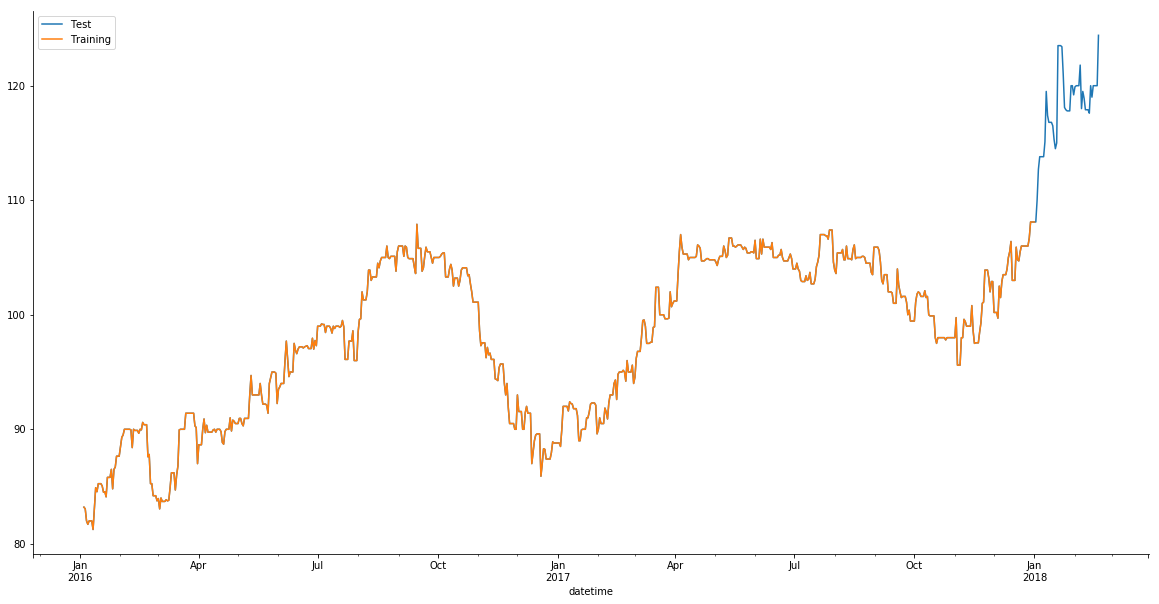

In [371]:
ax = yn_df.y.plot(figsize=(20, 10))
train.y.plot(ax=ax)
# Hide the right and top spines
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.legend(['Test', 'Training'])

# Only show ticks on the left and bottom spines
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

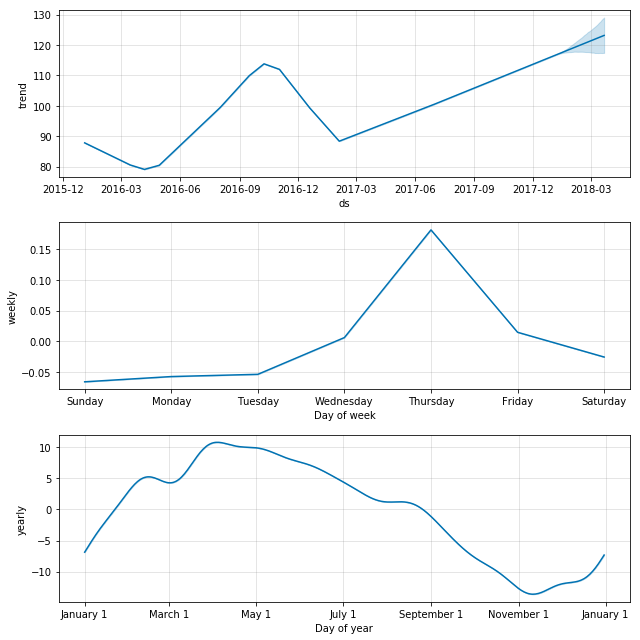

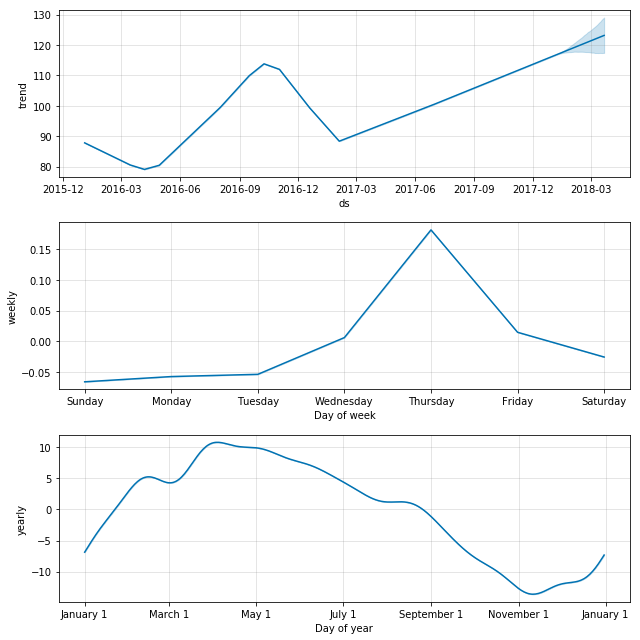

In [372]:
m.plot_components(forecast)

- Plot above shows that prices are higher on Aprils and on Thursdays.
- Lowest prices are on November/December, and on Mondays.

Above tells us that its best to buy at the end of the year, and on Mondays while its good to sell on April and on Thursdays.

# Prophet Forecast vs Actual BPI Close Price

In [393]:
test_df = pd.merge(forecast.set_index('ds')['2018':].reset_index(), test, on='ds', how='left')
test_df.index = test_df['ds']

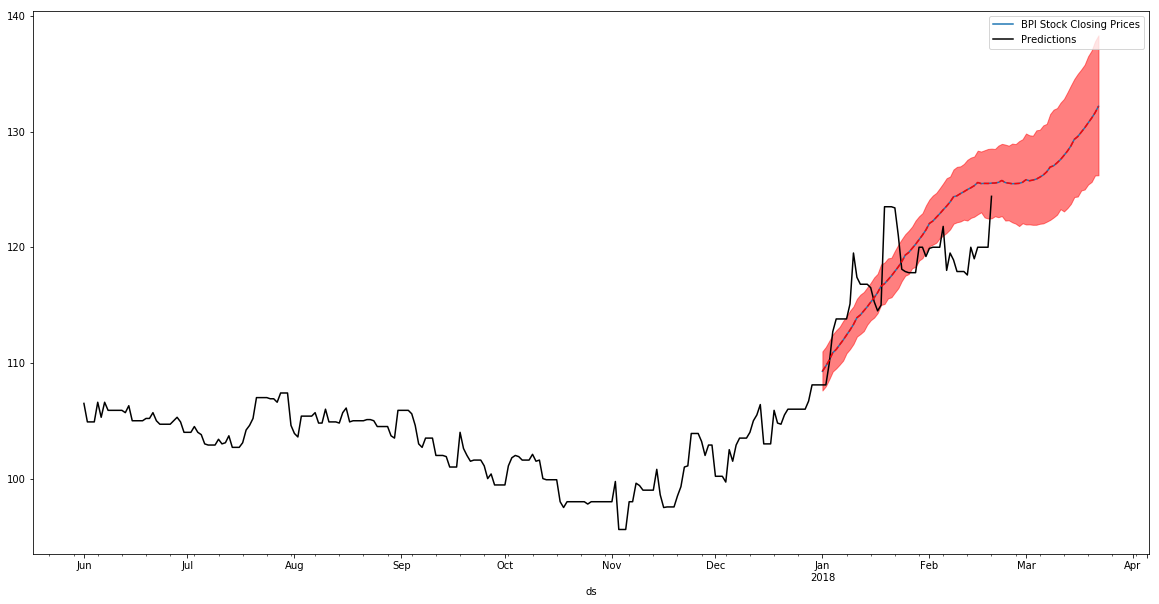

In [399]:
ax = test_df.yhat.plot(figsize=(20, 10))
yn_df['2017-06-01':].y.plot(ax=ax, color='Black')
test_df.yhat.plot(ax=ax, style='--', color='r')
ax.fill_between(test_df.index,
                test_df.yhat_lower,
                test_df.yhat_upper, color='r', alpha=.5)

plt.legend(['BPI Stock Closing Prices', 'Predictions'])
plt.show()
